In [257]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from datetime import datetime
%matplotlib inline

In [258]:
import fbprophet
print(fbprophet.__version__)

0.7.1


## Getting energy Data

In [259]:
states = ["AL", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
sectors = ['RES','COM',"IND"]

In [260]:
idx = 0
for state in states:
    for sector in sectors:
        response = requests.get("http://api.eia.gov/series/?api_key=e45b817b9a5449da30e0b88815d5f119&series_id=ELEC.SALES.{}-{}.M".format(state,sector))
        j = response.json()
        tmp = pd.DataFrame(j['series'][0]['data'],columns=['month','sales_mkwh'])
        tmp['state'] = state
        tmp['sector'] = sector
        if idx == 0:
            energy_data = tmp.copy()
        else:
            energy_data = energy_data.append(tmp)
        idx = idx +1

In [261]:
idx = 0
for state in states:
    for sector in sectors:
        response = requests.get("http://api.eia.gov/series/?api_key=e45b817b9a5449da30e0b88815d5f119&series_id=ELEC.PRICE.{}-{}.M".format(state,sector))
        j = response.json()
        tmp = pd.DataFrame(j['series'][0]['data'],columns=['month','price_cpkwh'])
        tmp['state'] = state
        tmp['sector'] = sector
        if idx == 0:
            energy_price_data = tmp.copy()
        else:
            energy_price_data = energy_price_data.append(tmp)
        idx = idx +1

In [262]:
energy_price_data.head()

,month,price_cpkwh,state,sector
0,202009,13.18,AL,RES
1,202008,12.76,AL,RES
2,202007,12.69,AL,RES
3,202006,12.93,AL,RES
4,202005,12.68,AL,RES


In [185]:
energy_data = energy_data.merge(energy_price_data,how='left',on=['month','state','sector'])

In [186]:
energy_data['sales'] = energy_data.sales_mkwh*energy_data.price_cpkwh

In [187]:
full_country = energy_data.groupby(['month','sector']).sum().reset_index()

In [188]:
full_country['state'] = 'USA'

In [190]:
full_country.price_cpkwh = full_country.sales/full_country.sales_mkwh

In [191]:
full_country.head()

,month,sector,sales_mkwh,price_cpkwh,sales,state
0,200101,COM,90368.23069,7.224387,652855.050742,USA
1,200101,IND,83071.44414,4.704050,390772.185618,USA
2,200101,RES,126612.09902,7.709981,976176.831703,USA
3,200102,COM,81038.27275,7.482378,606358.973331,USA
4,200102,IND,81877.17358,4.770198,390570.311697,USA


In [192]:
energy_data = energy_data.append(full_country[['month','sector','sales_mkwh','price_cpkwh','state']])

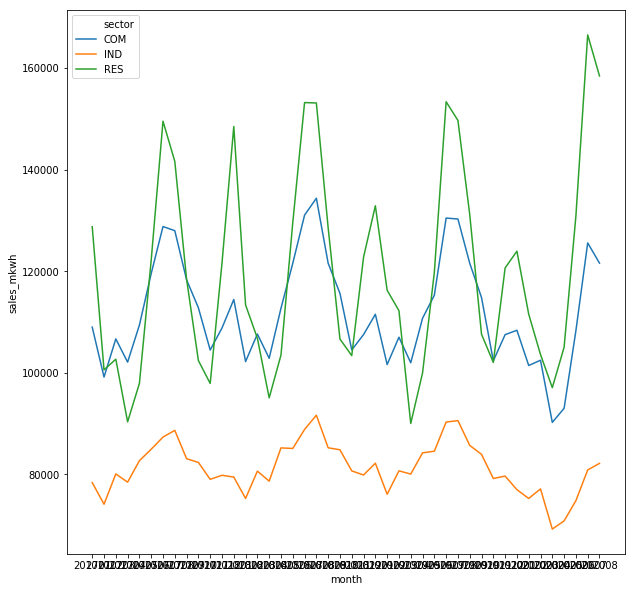

In [256]:
fig,ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=energy_data[(energy_data.state == 'USA')&(energy_data.year>=2017)],x='month',y='sales_mkwh',hue='sector')

In [194]:
energy_data['year'] = [int(m[0:4]) for m in energy_data.month]
energy_data['mon'] = [int(m[4:6]) for m in energy_data.month]

In [195]:
energy_data.head()

,month,sales_mkwh,state,sector,price_cpkwh,sales,year,mon
0,202008,3569.57496,AL,RES,12.76,45547.776490,2020,8
1,202007,3587.72858,AL,RES,12.69,45528.275680,2020,7
2,202006,2912.11315,AL,RES,12.93,37653.623029,2020,6
3,202005,2295.16194,AL,RES,12.68,29102.653399,2020,5
4,202004,1975.84717,AL,RES,12.87,25429.153078,2020,4


## Getting Policy Stringency Data

In [78]:
policy_stringency = pd.read_csv('https://raw.githubusercontent.com/OxCGRT/USA-covid-policy/master/data/OxCGRT_US_latest.csv')

/opt/conda/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning:

Columns (37) have mixed types.Specify dtype option on import or set low_memory=False.



In [79]:
policy_stringency.RegionCode = policy_stringency.RegionCode.fillna('USA_USA')

In [80]:
policy_stringency['state'] = [c.split('_')[1] for c in policy_stringency.RegionCode]

In [81]:
policy_stringency.head()

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C1_Notes,C2_Workplace closing,...,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay,state
0,United States,USA,NaN,USA_USA,NAT_GOV,20200101,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,USA
1,United States,USA,NaN,USA_USA,NAT_GOV,20200102,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,USA
2,United States,USA,NaN,USA_USA,NAT_GOV,20200103,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,USA
3,United States,USA,NaN,USA_USA,NAT_GOV,20200104,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,USA
4,United States,USA,NaN,USA_USA,NAT_GOV,20200105,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,USA


In [83]:
policy_stringency['date'] = [str(d)[0:6] for d in policy_stringency.Date]

In [84]:
policy_stringency = policy_stringency.groupby(['state','date']).median()['StringencyIndexForDisplay'].reset_index()

In [85]:
policy_stringency.date = [d+'01' for d in policy_stringency.date]
policy_stringency.date = pd.to_datetime(policy_stringency.date,format='%Y%m%d')

In [86]:
policy_stringency.head()

,state,date,StringencyIndexForDisplay
0,AK,2020-01-01,5.56
1,AK,2020-02-01,11.11
2,AK,2020-03-01,37.50
3,AK,2020-04-01,87.96
4,AK,2020-05-01,62.04


## Modeling with fb Prophet

In [107]:
def summer(ds):
#     date = pd.to_datetime(ds)
    if (ds.month > 7 and ds.month < 9):
        return 1
    else:
        return 0
# df_train['summer'] = df_train['ds'].apply(summer)

def fall(ds):
#     date = pd.to_datetime(ds)
    if (ds.month > 8 and ds.month < 10):
        return 1
    else:
        return 0
# df_train['fall'] = df_train['ds'].apply(fall)

def is_month(ds, mon):
    if ds.month == mon:
        return 1
    else:
        return 0

# months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
# for i in list(range(1,13)):
#     df_train['is_'+months[i-1]] = df_train['ds'].apply(is_month,mon=i)
    

In [161]:
energy_data['ds'] = [m+'01' for m in energy_data.month]
energy_data.ds = pd.to_datetime(energy_data.ds,format='%Y%m%d')

In [172]:
df_train = energy_data.copy()

In [174]:
states = list(energy_data.state.unique())
sectors = ['RES']
idx = 0
for s in states:
    for sec in sectors:
        print("{}-{}".format(s,sec))
        train_2018 = df_train[(df_train.state == s)&(df_train.sector == sec)&(df_train.year < 2019)].copy()
        train_2018 = train_2018[['ds','sales_mkwh']].rename(columns={'sales_mkwh':'y'})
        
        train_2019 = df_train[(df_train.state == s)&(df_train.sector == sec)&(df_train.year < 2020)].copy()
        train_2019 = train_2019[['ds','sales_mkwh']].rename(columns={'sales_mkwh':'y'})
        
        m_2018 = Prophet(seasonality_mode='multiplicative',yearly_seasonality=9,daily_seasonality=False,weekly_seasonality=False,mcmc_samples=200,growth='linear'
#                     ).add_seasonality(name='Four_year',period=365.25*4,fourier_order=3
#                     ).add_seasonality(name='Five_year',period=365.25*5,fourier_order=2
                    ).fit(train_2018)
        m_2019 = Prophet(seasonality_mode='multiplicative',yearly_seasonality=9,daily_seasonality=False,weekly_seasonality=False,mcmc_samples=200,growth='linear'
#                     ).add_seasonality(name='Four_year',period=365.25*4,fourier_order=3
#                     ).add_seasonality(name='Five_year',period=365.25*5,fourier_order=2
                    ).fit(train_2019)
        
        future_2018 = m_2018.make_future_dataframe(periods = 12, freq = 'MS')
        future_2019 = m_2019.make_future_dataframe(periods = 12, freq = 'MS')
        
        forecast_2018 = m_2018.predict(future_2018)
        forecast_2018['state'] = s
        forecast_2018['sector'] = sec
        forecast_2018 = forecast_2018[['ds','yhat','state','sector']].rename(columns={'yhat':'yhat_2018'})
        
        forecast_2019 = m_2019.predict(future_2019)
        forecast_2019['state'] = s
        forecast_2019['sector'] = sec
        forecast_2019 = forecast_2019[['ds','yhat','state','sector']].rename(columns={'yhat':'yhat_2019'})
        
        if idx == 0:
            df_test_2018 = forecast_2018.copy()
            df_test_2019 = forecast_2019.copy()
        else:
            df_test_2018 = df_test_2018.append(forecast_2018)
            df_test_2019 = df_test_2019.append(forecast_2019)
            
        idx = idx +1
        
df_train = df_train.merge(df_test_2018,how='left',on=['ds','state','sector']).merge(df_test_2019,how='left',on=['ds','state','sector'])
        

AL-RES
AK-RES
AZ-RES
AR-RES
CA-RES
CO-RES
CT-RES
DC-RES
DE-RES
FL-RES
GA-RES
HI-RES


ID-RES
IL-RES
IN-RES
IA-RES
KS-RES
KY-RES
LA-RES
ME-RES
MD-RES
MA-RES
MI-RES
MN-RES
MS-RES
MO-RES
MT-RES
NE-RES
NV-RES
NH-RES
NJ-RES
NM-RES
NY-RES
NC-RES
ND-RES
OH-RES


OK-RES
OR-RES
PA-RES
RI-RES
SC-RES
SD-RES
TN-RES
TX-RES
UT-RES
VT-RES
VA-RES
WA-RES
WV-RES
WI-RES
WY-RES
USA-RES


In [175]:
df_train.head()

,month,sales_mkwh,state,sector,year,mon,ds,yhat_2018,yhat_2019
0,202008,3569.57496,AL,RES,2020,8,2020-08-01,NaN,3428.089284
1,202007,3587.72858,AL,RES,2020,7,2020-07-01,NaN,3564.914325
2,202006,2912.11315,AL,RES,2020,6,2020-06-01,NaN,2963.350028
3,202005,2295.16194,AL,RES,2020,5,2020-05-01,NaN,2245.051647
4,202004,1975.84717,AL,RES,2020,4,2020-04-01,NaN,1973.173472


In [223]:
df_train['pct_error_2018'] = (-df_train.yhat_2018+df_train.sales_mkwh)*100/df_train.sales_mkwh
df_train['pct_error_2019'] = (-df_train.yhat_2019+df_train.sales_mkwh)*100/df_train.sales_mkwh

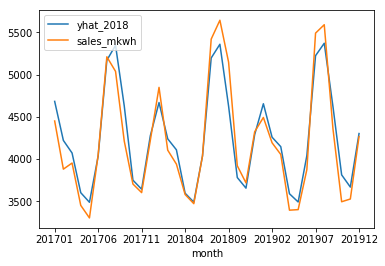

In [224]:
df_train[(df_train.state == 'NY')&(df_train.sector == 'RES')&(df_train.year>=2017)&(df_train.year<2020)].set_index('month').sort_index()[['yhat_2018','sales_mkwh']].plot()

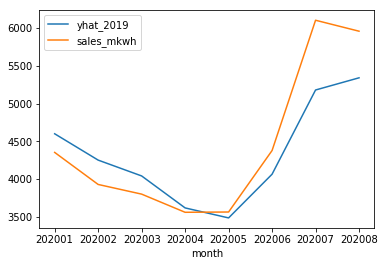

In [225]:
df_train[(df_train.state == 'NY')&(df_train.sector == 'RES')&(df_train.year>=2020)].set_index('month').sort_index()[['yhat_2019','sales_mkwh']].plot()

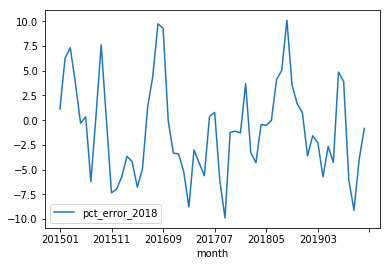

In [252]:
df_train[(df_train.state == 'NY')&(df_train.sector == 'RES')&(df_train.year>=2015)&(df_train.year<2020)].set_index('month').sort_index()[['pct_error_2018']].plot()

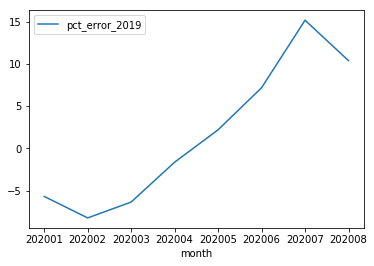

In [251]:
df_train[(df_train.state == 'NY')&(df_train.sector == 'RES')&(df_train.year>=2020)].set_index('month').sort_index()[['pct_error_2019']].plot()

In [140]:
# m = Prophet(seasonality_mode='multiplicative',yearly_seasonality=9,mcmc_samples=100,growth='linear'
# #         ).add_seasonality(name='Quarterly',period=365.25/4,fourier_order=6)
# #         ).add_seasonality(name='Half_yearly',period=365.25/2,fourier_order=2
#         ).add_seasonality(name='Four_year',period=365.25*4,fourier_order=3
#         ).add_seasonality(name='Five_year',period=365.25*5,fourier_order=2)
# #         ).add_seasonality(name='Three_year',period=365.25*2,fourier_order=5)
# #         ).add_seasonality(name='Two_year',period=365.25*2,fourier_order=5)
# # m.add_regressor('summer')
# # m.add_regressor('fall')

# # for i in list(range(0,12)):
# #     m.add_regressor('is_'+months[i])

# m.fit(df_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


/opt/conda/envs/py3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/conda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



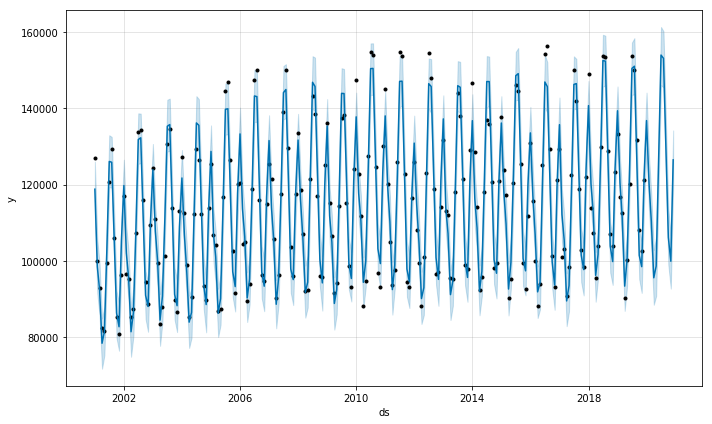

In [110]:
# future = m.make_future_dataframe(periods = 12, freq = 'MS')
# future['summer'] = future['ds'].apply(summer)
# future['fall'] = future['ds'].apply(fall)
# # for i in list(range(0,12)):
# #     future['is_'+months[i]] = future['ds'].apply(is_month,mon=i+1)
# forecast = m.predict(future)
# fig = m.plot(forecast)
# # a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
# cv_results = cross_validation(m,initial='6331 days', period='365.25 days', horizon = '365.25 days')

In [ ]:
# cv_results.head()

In [ ]:
# mse(cv_results.y, cv_results.yhat)

In [111]:
def mse(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    return np.nanmean(np.power((y-yhat),2))
def mape(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    return np.nanmean(np.abs((y-yhat)/y))*100

/opt/conda/envs/py3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/conda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/conda/envs/py3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/conda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ver

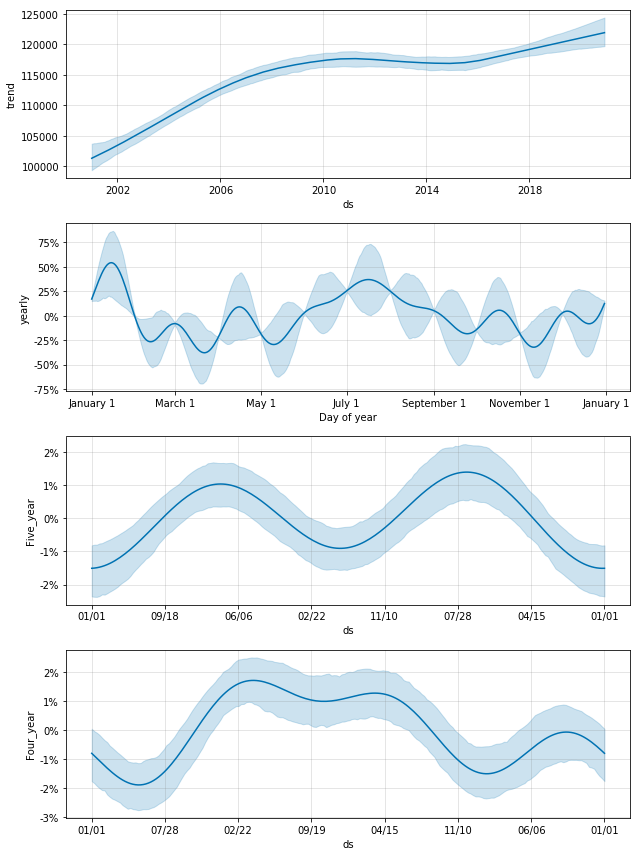

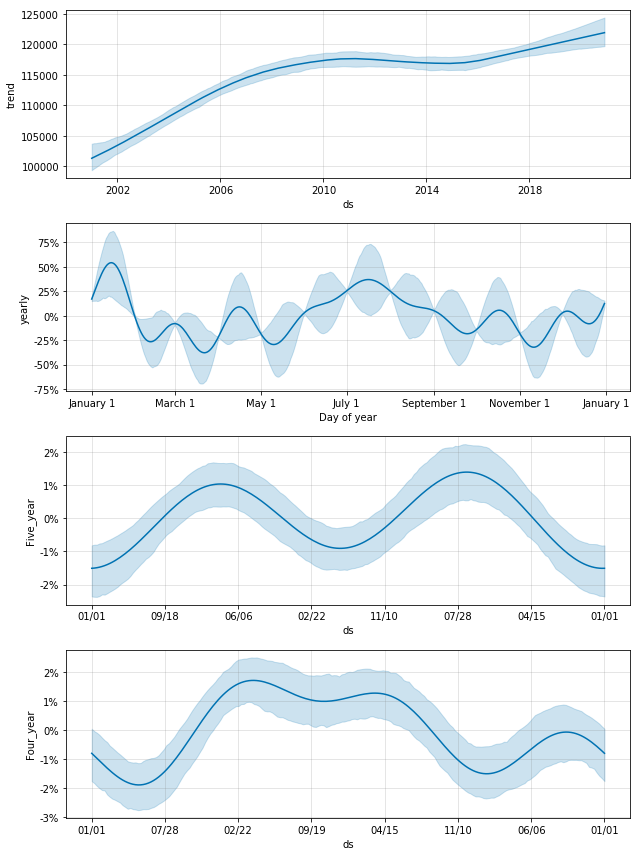

In [112]:
# m.plot_components(forecast)

- Train till 2018 and predict for 2019
- Compare predictions for 2019
- Average change pre-post lockdown

### Simple lagged diff

In [240]:
df_20 = energy_data[energy_data.year == 2020].copy()
df_19 = energy_data[energy_data.year == 2019].copy()
df_18 = energy_data[energy_data.year == 2018].copy()

In [241]:
df_19_20 = df_20.merge(df_19,how='left',on=['mon','sector','state'])
df_18_19 = df_19.merge(df_18,how='left',on=['mon','sector','state'])

In [242]:
df_lagged = pd.concat([df_18_19,df_19_20])

In [243]:
df_lagged.head()

,month_x,sales_mkwh_x,state,sector,price_cpkwh_x,sales_x,year_x,mon,month_y,sales_mkwh_y,price_cpkwh_y,sales_y,year_y
0,201912,2581.19517,AL,RES,11.19,28883.573952,2019,12,201812,2811.82645,11.55,32476.595498,2018
1,201911,2290.52849,AL,RES,12.47,28562.890270,2019,11,201811,2334.69273,12.07,28179.741251,2018
2,201910,2410.15949,AL,RES,12.86,30994.651041,2019,10,201810,2372.49220,12.33,29252.828826,2018
3,201909,3335.75365,AL,RES,12.61,42063.853527,2019,9,201809,3147.04027,12.38,38960.358543,2018
4,201908,3457.05464,AL,RES,12.81,44284.869938,2019,8,201808,3336.53819,12.32,41106.150501,2018


In [244]:
df_lagged['diff'] = df_lagged.sales_mkwh_x - df_lagged.sales_mkwh_y

In [245]:
df_lagged.head()

,month_x,sales_mkwh_x,state,sector,price_cpkwh_x,sales_x,year_x,mon,month_y,sales_mkwh_y,price_cpkwh_y,sales_y,year_y,diff
0,201912,2581.19517,AL,RES,11.19,28883.573952,2019,12,201812,2811.82645,11.55,32476.595498,2018,-230.63128
1,201911,2290.52849,AL,RES,12.47,28562.890270,2019,11,201811,2334.69273,12.07,28179.741251,2018,-44.16424
2,201910,2410.15949,AL,RES,12.86,30994.651041,2019,10,201810,2372.49220,12.33,29252.828826,2018,37.66729
3,201909,3335.75365,AL,RES,12.61,42063.853527,2019,9,201809,3147.04027,12.38,38960.358543,2018,188.71338
4,201908,3457.05464,AL,RES,12.81,44284.869938,2019,8,201808,3336.53819,12.32,41106.150501,2018,120.51645


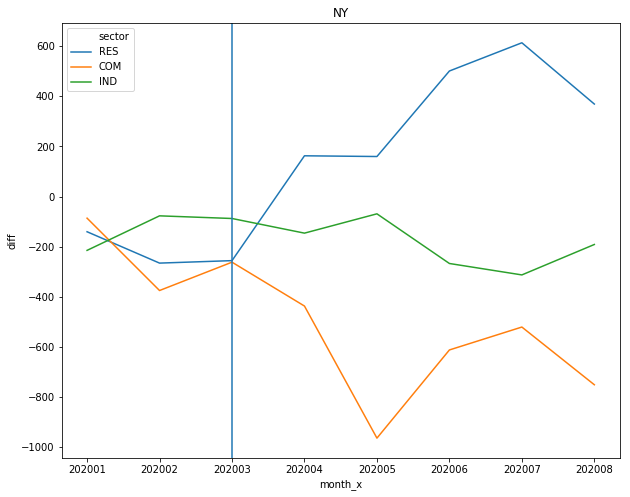

In [246]:
STATE = 'NY'
fig,ax = plt.subplots(figsize=(10,8))
sns.lineplot(data=df_lagged[(df_lagged.state == STATE)&(df_lagged.year_x>2019)],x='month_x',y='diff',hue='sector')
ax.set_title(STATE)
plt.axvline(x='202003')

Text(0.5, 1.0, 'CA')

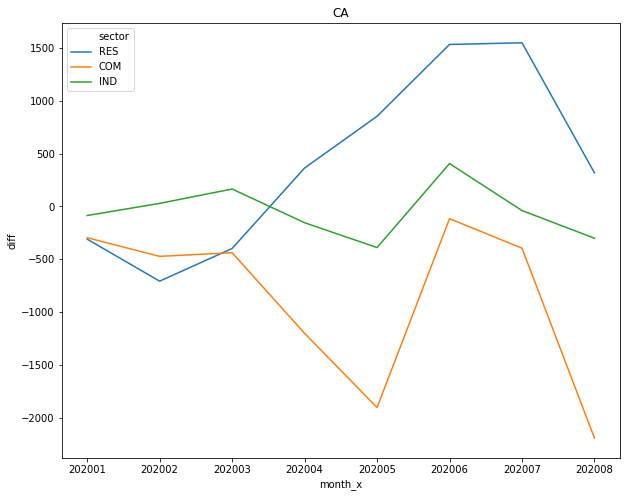

In [247]:
STATE = 'CA'
fig,ax = plt.subplots(figsize=(10,8))
sns.lineplot(data=df_lagged[(df_lagged.state == STATE)&(df_lagged.year_x>2019)],x='month_x',y='diff',hue='sector')
ax.set_title(STATE)

Text(0.5, 1.0, 'TX')

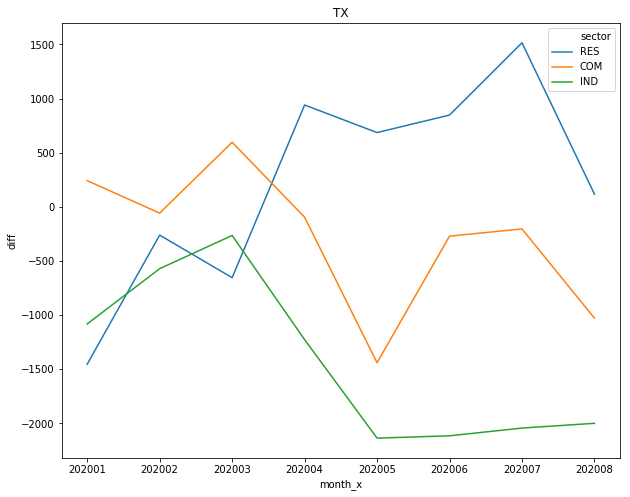

In [248]:
STATE = 'TX'
fig,ax = plt.subplots(figsize=(10,8))
sns.lineplot(data=df_lagged[(df_lagged.state == STATE)&(df_lagged.year_x>2019)],x='month_x',y='diff',hue='sector')
ax.set_title(STATE)

Text(0.5, 1.0, 'FL')

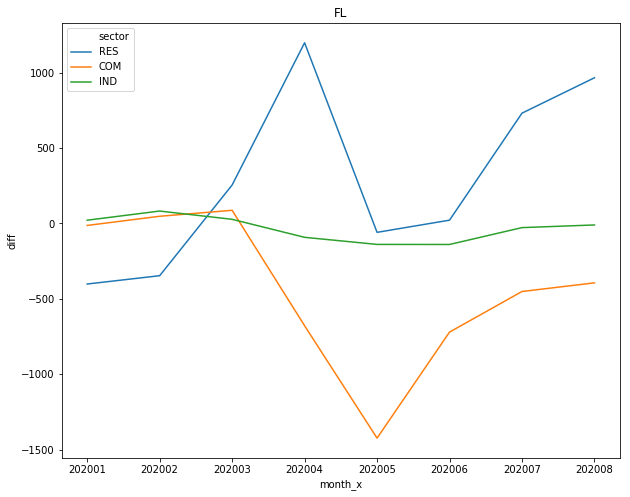

In [249]:
STATE = 'FL'
fig,ax = plt.subplots(figsize=(10,8))
sns.lineplot(data=df_lagged[(df_lagged.state == STATE)&(df_lagged.year_x>2019)],x='month_x',y='diff',hue='sector')
ax.set_title(STATE)

Text(0.5, 1.0, 'AL')

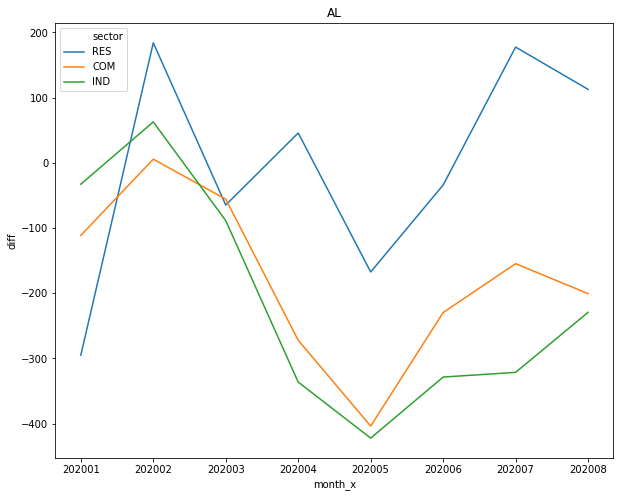

In [250]:
STATE = 'AL'
fig,ax = plt.subplots(figsize=(10,8))
sns.lineplot(data=df_lagged[(df_lagged.state == STATE)&(df_lagged.year_x>2019)],x='month_x',y='diff',hue='sector')
ax.set_title(STATE)